# Detecting macro- centers in a city

In [1]:
import osmnx as ox
import networkx as nx
import time
from shapely.geometry import Point
from sklearn.cluster import DBSCAN

#utilities not core
import matplotlib.pyplot as plt
from types import SimpleNamespace
from geopy.geocoders import Nominatim


# Define your city
city = SimpleNamespace(name="Athens")
city_name = city.name


1. Get the Full Street Network

Use osmnx to download a drive network of the city:

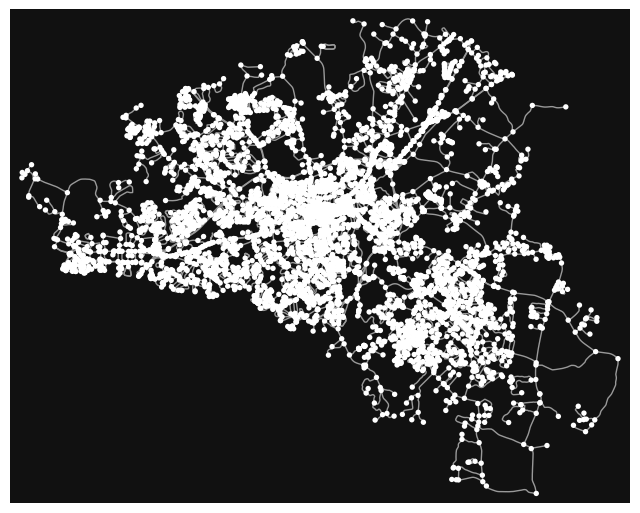

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [18]:
# Get a street network for a broad enough area
G = ox.graph_from_place(city.name, network_type='drive', simplify=True)
#project it
G_proj = ox.project_graph(G)
# Convert to undirected for basic layout
G_simple = G_proj.to_undirected()
ox.plot_graph(G_simple)

In [1]:
import community as community_louvain


ModuleNotFoundError: No module named 'community'

## 1. Load Points of Interest (POIs) from OpenStreetMap

C:\Users\froum\AppData\Local\Temp\ipykernel_52360\1152039765.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois['geometry'] = pois.geometry.centroid  # now it's in projected coordinates, so safe!


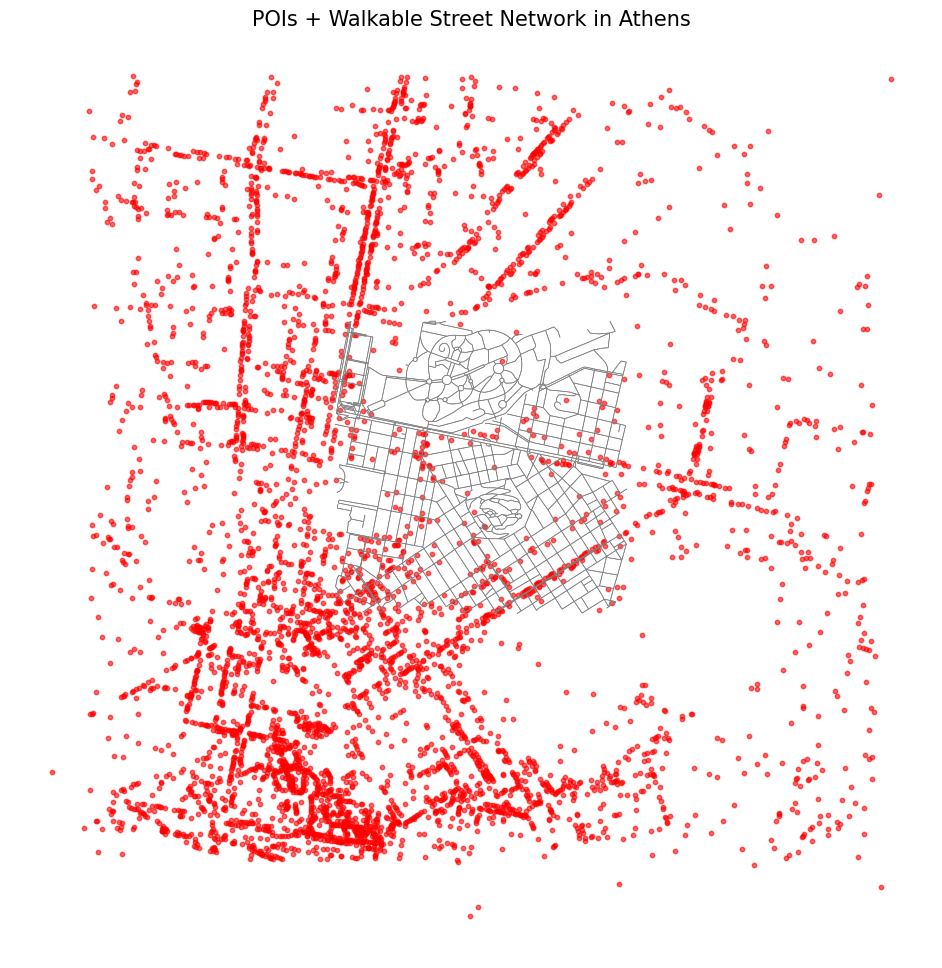

In [3]:
# 1. Load Points of Interest (POIs) from OpenStreetMap
import osmnx as ox
import matplotlib.pyplot as plt

# Define coordinate
coord = (37.989702027509686, 23.738142824327344)

# Load POIs
tags = {'shop': True, 'office': True, 'leisure': True}
pois = ox.features.features_from_point(coord, tags, dist=1600)

# Load walking street network
G = ox.graph_from_point(coord, dist=600, network_type='walk')
nodes, edges = ox.graph_to_gdfs(G)

# Reproject POIs to match edges CRS (a projected CRS)
pois = pois.to_crs(edges.crs)

# Keep only points & polygons, convert polygons to centroids
pois = pois[pois.geometry.type.isin(['Point', 'Polygon', 'MultiPolygon'])]
pois['geometry'] = pois.geometry.centroid  # now it's in projected coordinates, so safe!

# Plot
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, color="gray")
pois.plot(ax=ax, color="red", markersize=10, alpha=0.6)
ax.set_title("POIs + Walkable Street Network in Athens", fontsize=15)
plt.axis("off")
plt.show()


In [4]:
# Step 2: Compute centrality and get top N central nodes
centrality = nx.closeness_centrality(G)
top_n = 8
central_nodes = sorted(centrality, key=centrality.get, reverse=True)[:top_n]

In [5]:
print (central_nodes)

[631608665, 358464012, 569850326, 9057281456, 1547255316, 1062776769, 569850329, 6520886260]


NameError: name 'labels' is not defined

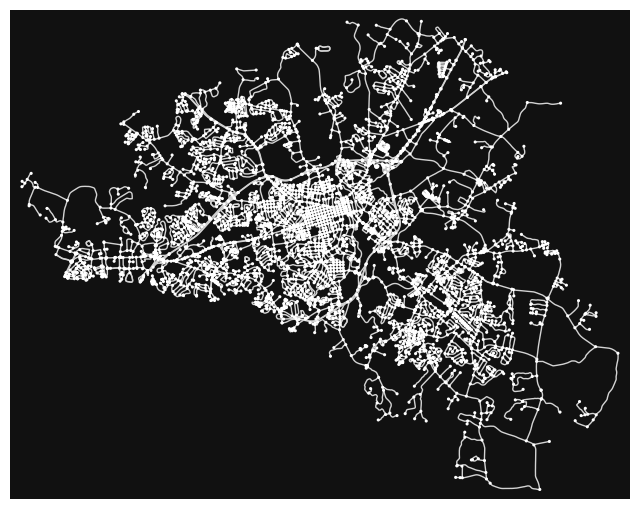

In [6]:

# Step 1: Plot the base graph
fig, ax = ox.plot_graph(G_simple, show=False, close=False, node_size=5, edge_color='lightgray')

# Step 2: Plot the central nodes on top
x = [G.nodes[node]['x'] for node in central_nodes]
y = [G.nodes[node]['y'] for node in central_nodes]
ax.scatter(x, y, c='red', s=50, zorder=3, label='Central Nodes')

# Step 3: Add labels if available
for node in central_nodes:
    label = labels.get(node, "")
    ax.annotate(label, (G.nodes[node]['x'], G.nodes[node]['y']),
                fontsize=7, color='darkred', xytext=(3,3), textcoords='offset points')

plt.title(f"{city_name} – Central Nodes on Street Network")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
super_centres = {
    "Athens Center": (37.9761, 23.7362),
    "Piraeus": (37.9426, 23.6469),
    "Kifisia": (38.0749, 23.8115),
    "Glyfada": (37.8781, 23.7483),
    "Marousi": (38.0568, 23.8081),
    "Nea Smyrni": (37.9452, 23.7120),
    "Peristeri": (38.0152, 23.6842)
}

In [11]:

# Tags for administrative boundaries
# More comprehensive place types
tags = {
    "place": [
        "suburb", "neighbourhood", "quarter", "city_block", "locality", "borough"
    ]
}
# Step 3: Download administrative polygons (suburbs/wards)
gdf_places = ox.features_from_place(city.name, tags)

# Filter to polygons only and keep 'name'
gdf_places = gdf_places[gdf_places.geometry.type.isin(["Polygon", "MultiPolygon"])]
gdf_places = gdf_places[["name", "geometry"]].dropna()
print (gdf_places)


                                                name  \
element id                                             
way     144093652                  Gabriel's Landing   
        144251529                        Tanglebrook   
        179466429                       Skyline Park   
        179489769                         Tanglewood   
        180572118                    Huntington Park   
        180606613                           Pinewood   
        180606632                          Mansfield   
        180612817                     Georgian Hills   
        180612818                         Towns Walk   
        180613812                      McNutts Creek   
        180965052                      Wexford Place   
        181010557                          Kingswood   
        181078627                          Glen Oaks   
        184787499                        Bowden Park   
        184924031                     Homewood Hills   
        184976954                       Chadd's 

In [12]:

# Step 4: Map each central node to its containing polygon
labels = {}
for node in central_nodes:
    lat = G.nodes[node]['y']
    lon = G.nodes[node]['x']
    point = Point(lon, lat)
    
    containing = gdf_places[gdf_places.contains(point)]
    if not containing.empty:
        labels[node] = containing.iloc[0]['name']
    else:
        labels[node] = f"{lat:.3f},{lon:.3f}"  # fallback if no name found


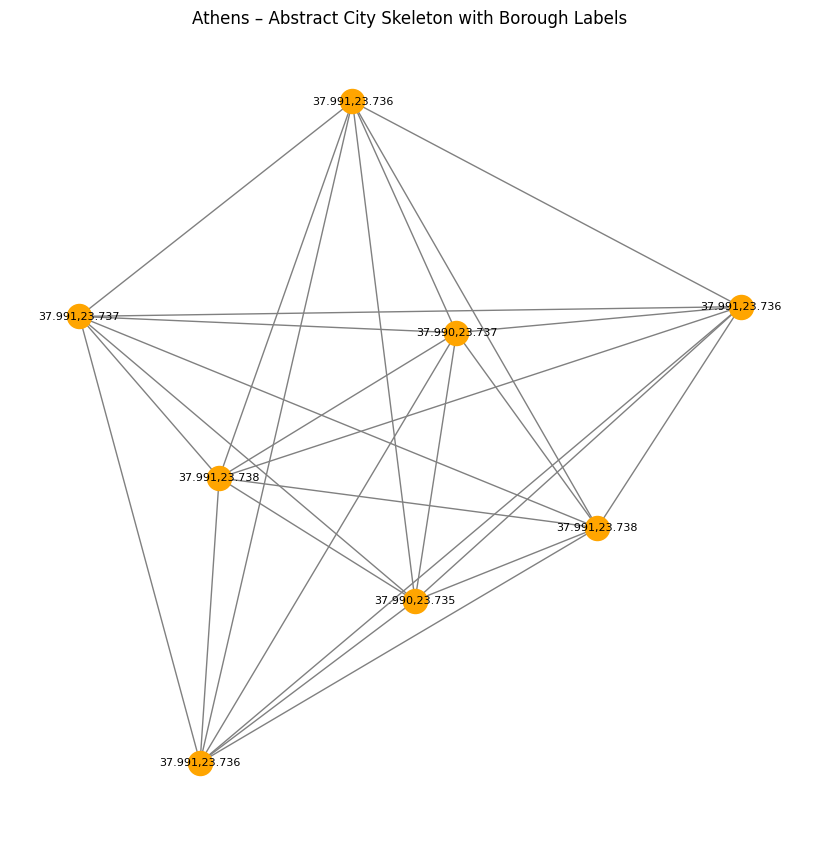

In [13]:
# Step 5: Create abstract graph from central nodes only
H = nx.Graph()
for node in central_nodes:
    H.add_node(node)

# Add edges between central nodes based on shortest path length
for i, node_i in enumerate(central_nodes):
    for j, node_j in enumerate(central_nodes):
        if i < j:
            try:
                length = nx.shortest_path_length(G, source=node_i, target=node_j, weight='length')
                H.add_edge(node_i, node_j, weight=length)
            except Exception:
                continue

# Step 6: Visualize simplified city skeleton
pos = nx.spring_layout(H, seed=42)  # spring layout = abstract layout
plt.figure(figsize=(8, 8))
nx.draw(H, pos, node_size=300, node_color="orange", edge_color="gray", with_labels=False)
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
plt.title(f"{city.name} – Abstract City Skeleton with Borough Labels")
plt.axis("off")
plt.show()

NetworkXError: Node 67219343 has no position.

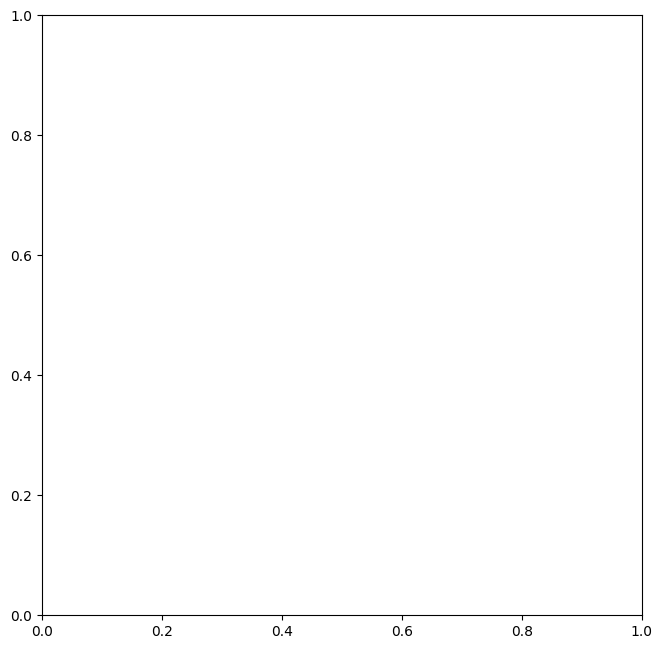

In [15]:

# Abstract layout (spring = stick-figure-like)
pos = nx.spring_layout(G_simple, k=0.15, iterations=50, seed=42)

# Draw the simplified node-edge graph
plt.figure(figsize=(6, 6))
nx.draw(G_simple, pos, node_size=5, edge_color="gray", node_color="skyblue")
plt.title(f"Abstract Graph of {city}")
plt.axis('off')
plt.tight_layout()
plt.show()